In [ ]:
pip install pretty_midi


**Justification:** MIDI handling.

In [ ]:
import os
import pretty_midi
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, DataCollatorForLanguageModeling, Trainer, default_data_collator
import music21
import subprocess
import warnings

# Suppress specific warnings from pretty_midi
warnings.filterwarnings("ignore", category=UserWarning, module='pretty_midi')

# Suppress all warnings from music21
warnings.filterwarnings("ignore", module='music21')

class MIDIDataset(Dataset):
    def __init__(self, root_dirs, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.files = []
        for root_dir in root_dirs:
            for subdir, _, files in os.walk(root_dir):
                for file in files:
                    if file.endswith('.midi') or file.endswith('.mid'):
                        self.files.append(os.path.join(subdir, file))

        # Pre-filter the dataset to remove invalid MIDI files
        self.files = self._filter_valid_files(self.files)
        # Calculate total duration
        self.total_duration = self.calculate_total_duration()

    def _filter_valid_files(self, files):
        valid_files = []
        for file in files:
            try:
                midi_data = pretty_midi.PrettyMIDI(file)
                if any(instrument.notes for instrument in midi_data.instruments):
                    valid_files.append(file)
                else:
                    print(f"No valid notes found in {file}. Skipping...")
            except Exception as e:
                print(f"Error reading {file}: {e}. Skipping...")
        return valid_files

    def calculate_total_duration(self):
        total_duration = 0.0
        for file in self.files:
            try:
                score = music21.converter.parse(file)
                total_duration += score.duration.quarterLength
            except Exception as e:
                print(f"Error processing {file}: {e}. Skipping...")
        return total_duration

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        midi_file = self.files[idx]
        midi_data = pretty_midi.PrettyMIDI(midi_file)

        # Flatten the notes to a simple sequence of pitch values
        notes = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append(note.pitch)

        # Convert the list of notes to a string
        notes_str = " ".join(map(str, notes))

        # Tokenize the notes string
        tokens = self.tokenizer(notes_str, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': tokens.input_ids.squeeze(0),
            'attention_mask': tokens.attention_mask.squeeze(0)
        }

# Initialize dataset paths
indian_dataset_path = '/content/drive/MyDrive/Dataset Music/Msc/Indian'  # Change to your "Indian" directory
western_dataset_path = '/content/drive/MyDrive/Dataset Music/Msc/Western'  # Change to your "Western" directory

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set the padding token
tokenizer.pad_token = tokenizer.eos_token

# Load both datasets and filter invalid files
combined_dataset = MIDIDataset(root_dirs=[indian_dataset_path, western_dataset_path], tokenizer=tokenizer)

# Print the total duration of the dataset
print(f"Total duration of the dataset: {combined_dataset.total_duration:.2f} quarter lengths")

# Split the dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Check if the combined dataset is empty and provide more informative error messages
if len(combined_dataset) == 0:
    raise ValueError("The combined dataset is empty. Please check if the directories contain valid MIDI files.")

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=default_data_collator)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=default_data_collator)

# Print the number of samples in the training and validation sets
print(f"Number of samples in the training set: {len(train_dataset)}")
print(f"Number of samples in the validation set: {len(val_dataset)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Bomfunk_MCs_-_Uprocking_Beats.mid: MThd not found. Probably not a MIDI file. Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Elmer_Bernstein_-_.mid: . Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Mahler_Gustav_-_Symphony_#2_(Tenor).mid: data byte must be in range 0..127. Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Mahler_Gustav_-_Symphony_#2_(Tenor2).mid: data byte must be in range 0..127. Skipping...
Error reading /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Unknown_-_pokemon.mid: list index out of range. Skipping...
No valid notes found in /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/Kona_-_Drumloop.mid. Skipping...
No valid notes found in /content/drive/MyDrive/Dataset Music/Msc/Western/Classic/un_debut_au_piano_-_my_first_composition.mid. Skipping...
Error reading /content/drive

**Justification:** The code snippet initializes a MIDI dataset for music generation using a pretrained GPT-2 model. It preprocesses MIDI files, handles invalid files, calculates dataset duration, and splits the data for training and validation. This setup is essential for developing a music generation model, leveraging GPT-2's capabilities for language modeling applied to musical note sequences.

In [ ]:
# Step 2: Model Preparation

# Load pre-trained GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Also set the model's padding token ID to eos token ID
model.config.pad_token_id = model.config.eos_token_id

# Step 3: Fine-Tuning the Model (GPT-2)

# Training arguments
train_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",  # Save model checkpoint every epoch
    report_to="none"  # Disable automatic logging to W&B or similar tools
)

# Create a data collator for language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Start training and evaluation
trainer.train()

# After training, you can evaluate the model on the validation set
eval_results = trainer.evaluate()

# Calculate perplexity from the loss
perplexity = torch.exp(torch.tensor(eval_results['eval_loss']))
print(f"Validation Perplexity: {perplexity.item()}")

# Save the trained model and tokenizer
model_save_path = './fine_tuned_gpt2_music_model'
tokenizer_save_path = './fine_tuned_gpt2_music_tokenizer'

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Model saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.052100,3.024129


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.052100,3.024129
2,2.888500,2.958613
3,2.770600,2.920875


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Validation Perplexity: 18.557514190673828
Model saved to ./fine_tuned_gpt2_music_model
Tokenizer saved to ./fine_tuned_gpt2_music_tokenizer



**Justification:** The code fine-tunes a GPT-2 model for music generation using MIDI data. It sets training parameters, manages data collation, evaluates model performance with perplexity, and saves the fine-tuned model and tokenizer for future use. This process customizes GPT-2 to generate music sequences based on the provided dataset.

In [ ]:
# Step 4: Generate Music Sequence Using the Fine-Tuned GPT-2 Model

# Example prompt for generating music (a simple sequence of note pitches)
input_prompt = "60 62 64 65"  # Example: MIDI pitch values for C, D, E, F
input_ids = tokenizer(input_prompt, return_tensors='pt').input_ids
attention_mask = tokenizer(input_prompt, return_tensors='pt').attention_mask

# Generate sequence using the fine-tuned model with sampling and repetition penalty
output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=100,
    num_return_sequences=1,
    do_sample=True,  # Enable sampling
    temperature=1.2,  # Increase randomness
    top_k=50,  # Limit the number of choices
    top_p=0.95,  # Use nucleus sampling
    repetition_penalty=2.0  # Penalize repetition
)

# Decode the generated output
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the generated sequence
print("Generated MIDI pitch sequence:", output_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated MIDI pitch sequence: 60 62 64 65 66 67 68 81 76 79 80 83 102 86 95 90 94 88 96 89 93 92 78 91 82 98 87 59 61 101 85 56 58 77 84 71 57 72 41 32 27 60 33 31 30 51 40 42 35 38 45 36 34 28 23 29 21 54 18 24 17 37 69 49 55 52 25 50 47 26 53 46 22 39 44 75 74 0 70 48 43 19 73 20 15 14 99 100 2 97 1 103 63 116 104 112 4 126 12 16



**Justification:** The code generates a new music sequence using a fine-tuned GPT-2 model by inputting a prompt of MIDI pitch values. It utilizes sampling techniques to create diverse and non-repetitive sequences, then decodes the output into a readable format. This enables the model to creatively extend a given musical idea.

In [ ]:
# Step 5: Convert the Generated Sequence to a music21 Score

# Convert the generated sequence to a music21 score
def convert_sequence_to_score(sequence):
    notes = sequence.split()
    score = music21.stream.Score()
    part = music21.stream.Part()

    for pitch in notes:
        # Convert pitch from string to integer
        note_pitch = int(pitch)
        # Create a music21 Note object
        note = music21.note.Note(note_pitch)
        note.quarterLength = 0.5  # Set note duration, e.g., half a beat
        part.append(note)

    score.append(part)
    return score

# Example: Add chords to the score
def add_chords_to_score(score):
    chords = [
        music21.chord.Chord(['C4', 'E4', 'G4']),
        music21.chord.Chord(['F4', 'A4', 'C5']),
        music21.chord.Chord(['G4', 'B4', 'D5']),
        music21.chord.Chord(['C4', 'E4', 'G4'])
    ]

    for chord in chords:
        chord.quarterLength = 2  # Each chord lasts for two beats
        score.insert(chord.offset, chord)

    return score

# Example: Add lyrics to the score
def add_lyrics_to_score(score, lyrics):
    part = score.parts[0]
    for i, note in enumerate(part.notes):
        if i < len(lyrics):
            note.lyric = lyrics[i]

    return score

# Convert the generated sequence to a score
score = convert_sequence_to_score(output_text)

# Optionally, add chords and lyrics
score = add_chords_to_score(score)
lyrics = "This is a test of generated music".split()
score = add_lyrics_to_score(score, lyrics)

**Justification:** The code converts a generated MIDI pitch sequence into a music21 score, enabling further musical structuring and analysis. It adds flexibility by allowing the inclusion of chords and lyrics, enhancing the musical composition. This approach leverages music21's capabilities to create a more complete and musically rich output, transforming raw note sequences into structured and performable music.

In [ ]:
!apt-get update
!apt-get install musescore3

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,173 kB]
Get:14 http://security.ubuntu.com/ub

**Justification:** The commands update the package lists on the system and install MuseScore 3, a music notation software. MuseScore 3 is used for rendering and visually displaying the music scores generated by the music21 library, enabling users to view, edit, and export the scores as sheet music or audio files.

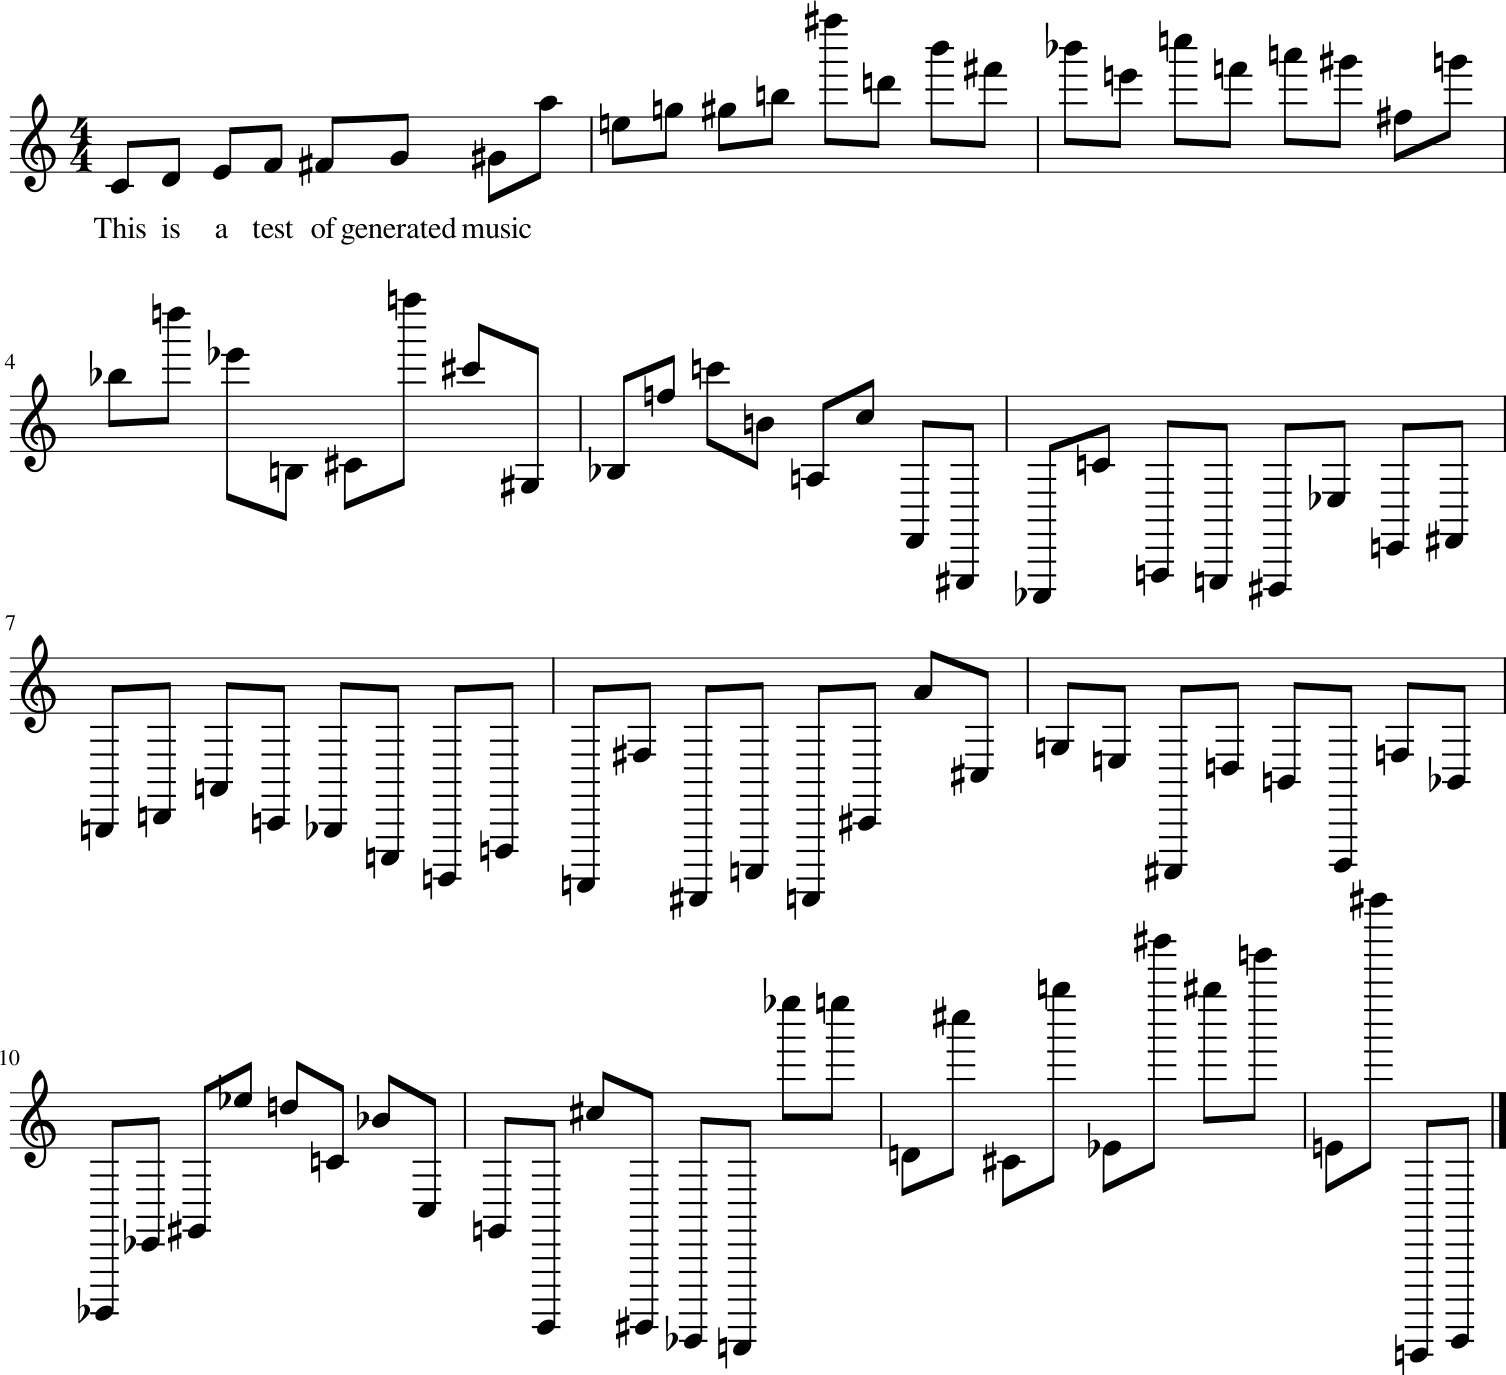

Saved MIDI file to generated_music21.mid


In [ ]:
# Step 6: Show and Save the Score as a MIDI File

# Show and save the score
def show_and_save_score(score, output_midi_file='generated_music21.mid'):
    score.show()  # This may open a music notation software viewer
    mf = music21.midi.translate.music21ObjectToMidiFile(score)
    mf.open(output_midi_file, 'wb')
    mf.write()
    mf.close()
    print(f"Saved MIDI file to {output_midi_file}")

# Show and save the score
show_and_save_score(score, 'generated_music21.mid')

**Justification:** The code shows the generated music score using a notation software and saves it as a MIDI file. This allows users to visually review the music and export it for playback or further editing. The saved MIDI file can be used in various digital audio workstations or shared with others, making the generated music more accessible and versatile.

In [ ]:
pip install pygame


In [ ]:
import music21

# Load the MIDI file
score = music21.converter.parse("/content/generated_music21.mid")

# Play the MIDI file
score.show('midi')



**Justification:** The code loads a MIDI file using the music21 library and plays it back. This allows users to quickly listen to the generated music directly within the environment, facilitating immediate auditory feedback and assessment of the music composition. The score.show('midi') function plays the MIDI file using a suitable MIDI player.